<a href="https://colab.research.google.com/github/aleksandr-del/yandex-praticum-projects/blob/main/yandex_practicum_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. 

В настоящем проекте нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Работу над проектом поделим на четыре части:

1. знакомство (исследование) с данными и составление плана работы;
2. уточнение задачи;
3. предобработка данных, разработка модели;
4. составление отчётаю

## Исследование данных

Импортируем необходимые для работы над проектом библиотеки, модули, функции:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

### Данные об электродах

Скачаем и сохраним в переменной `data_arc` данные об электродах:

In [ ]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

Выведим первые 5 строк датафрейма:

In [ ]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Общая информация о датафрейме:

In [ ]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [ ]:
print(f'Количество партий в данных: {data_arc["key"].nunique()}.')

Количество партий в данных: 3214.


In [ ]:
print(f"Максимальное количество итераций обработки партии: {data_arc['key'].value_counts().max()}.")
print(f"Минимальное количество итераций обработки партии: {data_arc['key'].value_counts().min()}.")
print(f"Среднее количество итераций обработки партии: {data_arc['key'].value_counts().mean()}.")

Максимальное количество итераций обработки партии: 16.
Минимальное количество итераций обработки партии: 1.
Среднее количество итераций обработки партии: 4.628500311138768.


Посмотрим на распределение признаков `Активная мощность` и `Реактивная мощность`:

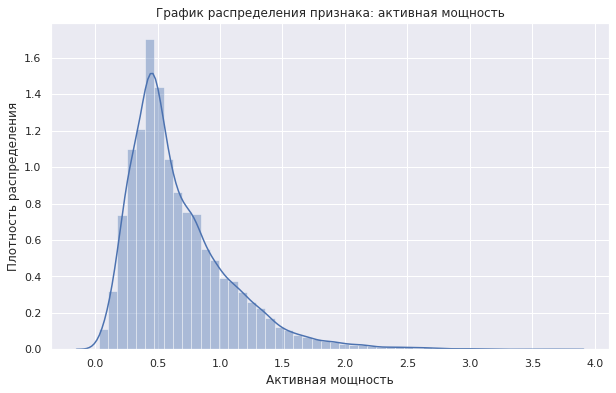

In [ ]:
plt.figure(figsize=(10, 6))
sns.distplot(data_arc['Активная мощность'])
plt.title('График распределения признака: активная мощность')
plt.xlabel('Активная мощность')
plt.ylabel('Плотность распределения')
plt.show();

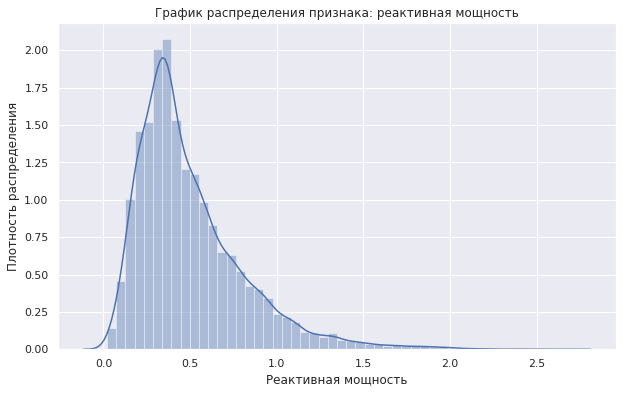

In [ ]:
plt.figure(figsize=(10, 6))
sns.distplot(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'])
plt.title('График распределения признака: реактивная мощность')
plt.xlabel('Реактивная мощность')
plt.ylabel('Плотность распределения')
plt.show();

Краткая описательная статистика:

In [ ]:
data_arc[['Активная мощность', 'Реактивная мощность']].describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


**Вывод**

В данных об электродах 14 786 наблюдений и 4 признака. Пропуски отсутствуют. Всего 3 124 партиий в данных.  

Распределение признака `Активная мощность` близко к нормальному со средним значением, равным 0.67, данные скошены вправо.

Распределение признака `Реактивная мощность` приблизительно нормальное со средним значением, равным 0.4526, данные скошены влево: наблюдаются аномальные отрицательные значения, расположенные за границей 3 стандартных отклонений.

###  Данные о подаче сыпучих материалов: объем и время

Скачаем и сохраним в переменной `data_bulk` данные об объеме подачи сыпучих материалов:

In [ ]:
data_bulc = pd.read_csv('/datasets/final_steel/data_bulk.csv')

Выведим первые 5 строк датафрейма:

In [ ]:
data_bulc.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Общая информация о датафрейме `data_bulc`:

In [ ]:
data_bulc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [ ]:
print(f'Количество партий в данных: {data_bulc["key"].nunique()}.')

Количество партий в данных: 3129.


Визуализируем распределение значений признаков таблицы `data_bulk`, предварительно заменив пропуски нулями:

Text(0.5, 0, 'Bulks')

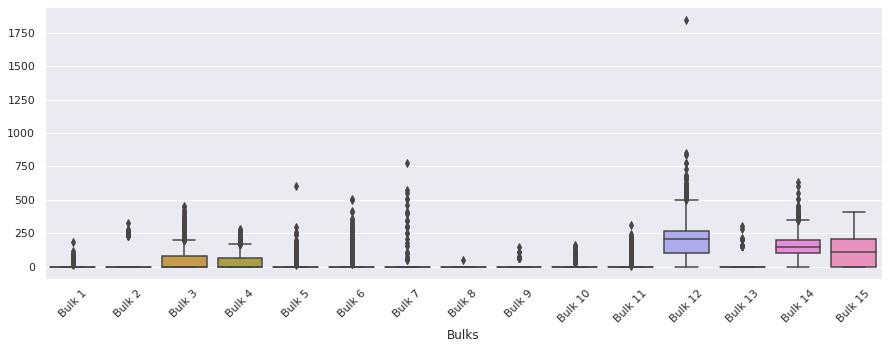

In [ ]:
sns.set(rc={'figure.figsize': (15, 5)})
ax = sns.boxplot(data=data_bulc.drop(columns='key').fillna(0))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Bulks')

Скачаем и сохраним в переменной `data_bulk_time` данные об объеме подачи сыпучих материалов:

In [ ]:
data_bulc_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

Выведим первые 5 строк датафрейма:

In [ ]:
data_bulc_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Общая информация о датафрейме `data_bulc_time`:

In [ ]:
data_bulc_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [ ]:
print(f'Количество партий в данных: {data_bulc_time["key"].nunique()}.')

Количество партий в данных: 3129.


Проверим, совпадает ли количество пропусков в признаках в обоих датасетах:

In [ ]:
data_bulc.isna().sum() == data_bulc_time.isna().sum()

key        True
Bulk 1     True
Bulk 2     True
Bulk 3     True
Bulk 4     True
Bulk 5     True
Bulk 6     True
Bulk 7     True
Bulk 8     True
Bulk 9     True
Bulk 10    True
Bulk 11    True
Bulk 12    True
Bulk 13    True
Bulk 14    True
Bulk 15    True
dtype: bool

**Вывод**

В данных об объеме и времени подачи сыпучих матеиалов 3 129 наблюдений и 16 признаков. Во всех признаках, кроме `key`, есть пропуски. Количество пропусков в признаках каждого датафрейма совпадает. Всего 3 129 партий в данных.

###  Данные о продувке сплава газом

Скачаем и сохраним в переменной `data_gas` данные о  продувке сплава газом:

In [ ]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

Выведим первые 5 строк датафрейма:

In [ ]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Общая информация о датафрейме:

In [ ]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
print(f'Количество партий в данных: {data_gas["key"].nunique()}.')

Количество партий в данных: 3239.


Посмотрим на распределение признака `Газ 1`:

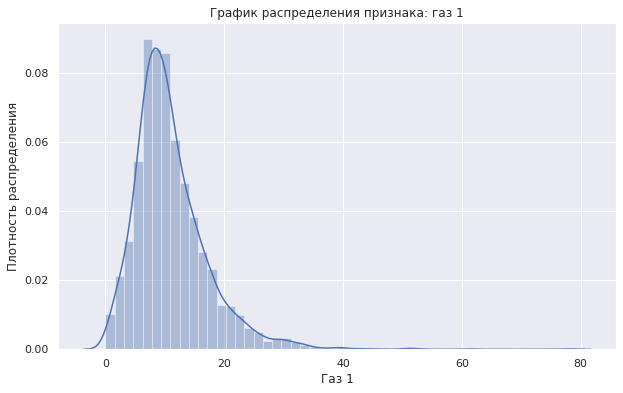

In [ ]:
plt.figure(figsize=(10, 6))
sns.distplot(data_gas['Газ 1'])
plt.title('График распределения признака: газ 1')
plt.xlabel('Газ 1')
plt.ylabel('Плотность распределения')
plt.show();

Краткая описательная статистика:

In [ ]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

**Вывод**

В данных о продувке сплава газом 3 239 наблюдений и 2 признака. Попуски отсутствуют. Всего 3 239 партий в данных. 

Распределение признака `Газ 1` близко к нормальному со средним значением, равным 11.0, данные скошены вправо: наблюдаются аномально высокие значения, расположенные за границей 3 стандартных отклонений.

### Данные о результатах измерения температуры

Скачаем и сохраним в переменной `data_temp` данные о результатах измерения температуры:

In [ ]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

Выведим первые 5 строк датафрейма:

In [ ]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Общая информация о датафрейме:

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [ ]:
print(f'Количество партий в данных: {data_temp["key"].nunique()}.')

Количество партий в данных: 3216.


In [ ]:
print(f"Максимальное количество измерений температуры партии: {data_temp['key'].value_counts().max()}.")
print(f"Минимальное количество измерений температуры партии: {data_temp['key'].value_counts().min()}.")
print(f"Среднее количество измерений температуры партии: {data_temp['key'].value_counts().mean()}.")

Максимальное количество измерений температуры партии: 16.
Минимальное количество измерений температуры партии: 1.
Среднее количество измерений температуры партии: 4.946206467661692.


Посмотрим на распределение признака `Температура`:

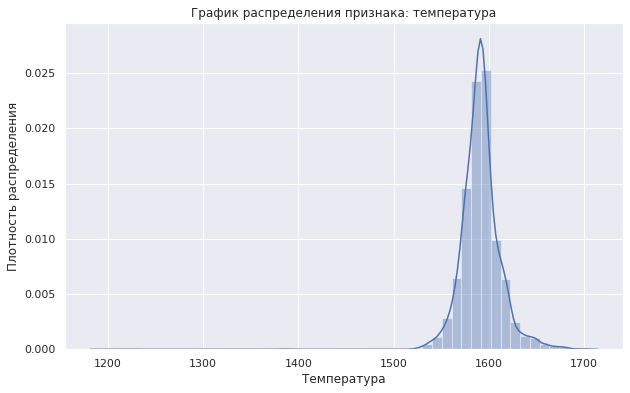

In [ ]:
plt.figure(figsize=(10, 6))
sns.distplot(data_temp['Температура'])
plt.title('График распределения признака: температура')
plt.xlabel('Температура')
plt.ylabel('Плотность распределения')
plt.show();

Краткая описательная статистика:

In [ ]:
data_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

**Вывод**

В данных о результатах измерения температуры 15 907 наблюдений и 3 признака. Есть пропси в признаке `Температура`. Всего 3 216 партий в данных. 

Распределение признака `Температура` близко к нормальному со средним значением, равным 1 591.84, данные скошены немного влево: наблюдаются аномально низкие значения, расположенные за границей 3 стандартных отклонений.

### Данные о проволочных материалах: объем и время

Скачаем и сохраним в переменной `data_bulk` данные об объеме подачи сыпучих материалов:

In [ ]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

Выведим первые 5 строк датафрейма:

In [ ]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Общая информация о датафрейме `data_wire`:

In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
print(f'Количество партий в данных: {data_wire["key"].nunique()}.')

Количество партий в данных: 3081.


Визуализируем распределение значений признаков таблицы `data_wire`, предварительно заменив пропуски нулями:

Text(0.5, 0, 'Wires')

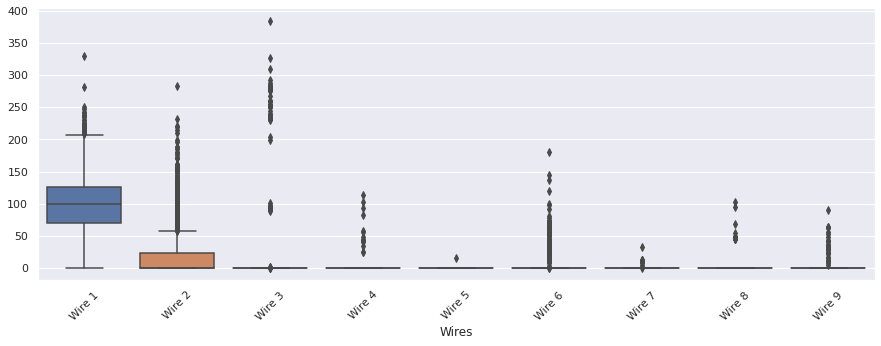

In [ ]:
sns.set(rc={'figure.figsize': (15, 5)})
ax = sns.boxplot(data=data_wire.drop(columns='key').fillna(0))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Wires')

Скачаем и сохраним в переменной `data_wire_time` данные об объеме подачи сыпучих материалов:

In [ ]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Выведим первые 5 строк датафрейма:

In [ ]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Общая информация о датафрейме `data_wire_time`:

In [ ]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [ ]:
print(f'Количество партий в данных: {data_wire_time["key"].nunique()}.')

Количество партий в данных: 3081.


Проверим, совпадает ли количество пропусков в признаках в обоих датасетах:

In [ ]:
data_wire.isna().sum() == data_wire_time.isna().sum()

key       True
Wire 1    True
Wire 2    True
Wire 3    True
Wire 4    True
Wire 5    True
Wire 6    True
Wire 7    True
Wire 8    True
Wire 9    True
dtype: bool

**Вывод**

В данных об объеме и времени подачи сыпучих матеиалов 3 081 наблюдений и 0 признаков. Во всех признаках, кроме `key`, есть пропуски. Количество пропусков в признаках каждого датафрейма совпадает. Всего 3 081 партий в данных.

## Предобработка данных

### Данные об электродах

Найдем наблюдения с аномальными отрицательными значениями признака `Реактивная мощность`:

In [ ]:
data_arc[data_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


В данных только одно наблюдение с отрицательным значением признака `Реактивная мощность`. Предлагаем восстановить значение через среднее отношение признака `Активная мощность` к `Рективной мощности`:

In [ ]:
ratio = data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].mean() / data_arc[data_arc['Реактивная мощность'] > 0]['Активная мощность'].mean()

In [ ]:
data_arc.loc[data_arc['Реактивная мощность'] <= 0, 'Реактивная мощность'] = data_arc.loc[data_arc['Реактивная мощность'] <= 0, 'Активная мощность'] * ratio

Сгруппируем данные по `key` (номеру партии), суммируем значения признаков каждой партии, сохраним сводную таблицу как датафрейм в той же переменной `data_arc`:

In [ ]:
data_arc = data_arc.groupby('key')[['Активная мощность', 'Реактивная мощность']].sum().reset_index()

Убедимся, что в переменной `data_arc` мы сохранили новый датафрейм:

In [ ]:
data_arc.head()

,key,Активная мощность,Реактивная мощность
0,1,4.878147,3.183241
1,2,3.052598,1.998112
2,3,2.525882,1.599076
3,4,3.209250,2.060298
4,5,3.347173,2.252643


### Данные об объемах подачи сыпучих материалов

Все пропуски в таблице `data_bulc` заменяем нулевыми значениями:

In [ ]:
data_bulc = data_bulc.fillna(0)

Проверим результат заполнения пропусков:

In [ ]:
data_bulc.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Убедимся, что в `data_bulc` отсутствуют признаки, в которых все значения нулевые:

In [ ]:
(data_bulc == 0).sum() == len(data_bulc)

key        False
Bulk 1     False
Bulk 2     False
Bulk 3     False
Bulk 4     False
Bulk 5     False
Bulk 6     False
Bulk 7     False
Bulk 8     False
Bulk 9     False
Bulk 10    False
Bulk 11    False
Bulk 12    False
Bulk 13    False
Bulk 14    False
Bulk 15    False
dtype: bool

### Данные о результатах измерения температуры:

Преобразуем строковый тип данных признака `Время замера` в тип данных `datetime`:

In [ ]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

Убедимся, что преобразование произведено корректно:

In [ ]:
data_temp.dtypes

key                      int64
Время замера    datetime64[ns]
Температура            float64
dtype: object

Для убедительности и уверенности сортируем данные по `key`  и `Время замера`:

In [ ]:
data_temp = data_temp.sort_values(by=['key', 'Время замера'])

Убедимся, что в столбце `Температура` отсутствуют нулевые значения:

In [ ]:
(data_temp['Температура'] == 0).sum()

0

В качестве признака будем использовать первое по времени измерение температуры каждой партии, а в качестве целевого признака - последнее по времени измерение температуры каждой партии. Так как возможно, что первое и/или последнее по времени измерение температуры будет неизвестно (пропущенное значение), то такие партии необходимо исключить. Так же необходимо исключить партии, где у нас всего одно измерение температуры.

Для этого сначала заполняем пропуски в столбце `Температура` нулевыми значениями:

In [ ]:
data_temp['Температура'] = data_temp['Температура'].fillna(0)

Потом группируем данные по `key`, находим первое и последнее измерение температуры, считаем количество измерений, сводную таблицу преобразуем в датафрейм и сохраняем в той же переменной

In [ ]:
data_temp = data_temp.groupby('key')['Температура'].agg(['first', 
                                                         'last', 
                                                         'count']).reset_index()

Проверим результат:

In [ ]:
data_temp.head()

,key,first,last,count
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5
3,4,1601.0,1625.0,3
4,5,1576.0,1602.0,2


Найдем партии, где всего одно измерение:

In [ ]:
data_temp[data_temp['count'] <= 1]

,key,first,last,count
192,195,1583.0,1583.0,1
276,279,1603.0,1603.0,1


Удалим из таблицы партии, где всего одно измерение, удалим столбец `count`:

In [ ]:
data_temp = data_temp[data_temp['count'] > 1]
data_temp = data_temp.drop(columns='count')

Найдем партии, где значения первого и/или последнего по времени измерения температуры были пропущены, то есть равны нулю:

In [ ]:
data_temp[(data_temp['first'] == 0) | (data_temp['last'] == 0)]

,key,first,last
2477,2500,1539.0,0.0
2478,2501,1587.0,0.0
2479,2502,1583.0,0.0
2480,2503,1603.0,0.0
2481,2504,1583.0,0.0
...,...,...,...
3211,3237,1569.0,0.0
3212,3238,1584.0,0.0
3213,3239,1598.0,0.0
3214,3240,1617.0,0.0


Так как у нас нет возможности восстановить пропущенные значения первого и/или последнего измерения температуры, предлагам такие партии удалить из выборки. Также предлагаем удалить партии, где значения температуры ниже 1500 градусов, что находится за пределами нижней границы 3-х стандартных отклонений и считается аномалией:

In [ ]:
data_temp = data_temp[(data_temp['first'] > 1500) & (data_temp['last'] > 1500)]

Переименуем столбцы:

In [ ]:
data_temp.columns = ['key', 'first_temp', 'last_temp']

Общая информация о таблице:

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2471 non-null   int64  
 1   first_temp  2471 non-null   float64
 2   last_temp   2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


После обработки и преобразования данных о результатах измерения температуры в нашем распоряжении остались наблюдения о 2 471 партии.

### Данные об объемах проволочных материалов

Еще раз проверим пропуски в признаках:

In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


У признака `Wire 5` всего одно непропущенное значение. Предлагаем удалить его, а все остальные пропуски заполнить нулями:

In [ ]:
data_wire = data_wire.drop(columns='Wire 5')

In [ ]:
data_wire = data_wire.fillna(0)

## Объединение таблиц в один датасет

Объединим все таблицы в единый датасет, включив в него только те партии, ключи которых есть во всех таблицах:

In [ ]:
df = reduce(lambda x, y: pd.merge(x, y, on='key', how='inner'), [data_arc,
                                                            data_bulc,
                                                            data_gas,
                                                            data_wire,
                                                            data_temp])

df.head()

,key,Активная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,first_temp,last_temp
0,1,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0
1,2,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0
2,3,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0
3,4,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1625.0
4,5,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1602.0


Общая информация о таблице:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2325 non-null   int64  
 1   Активная мощность    2325 non-null   float64
 2   Реактивная мощность  2325 non-null   float64
 3   Bulk 1               2325 non-null   float64
 4   Bulk 2               2325 non-null   float64
 5   Bulk 3               2325 non-null   float64
 6   Bulk 4               2325 non-null   float64
 7   Bulk 5               2325 non-null   float64
 8   Bulk 6               2325 non-null   float64
 9   Bulk 7               2325 non-null   float64
 10  Bulk 8               2325 non-null   float64
 11  Bulk 9               2325 non-null   float64
 12  Bulk 10              2325 non-null   float64
 13  Bulk 11              2325 non-null   float64
 14  Bulk 12              2325 non-null   float64
 15  Bulk 13              2325 non-null   f

На тепловой карте визуализируем линейную корреляцию между признаками:

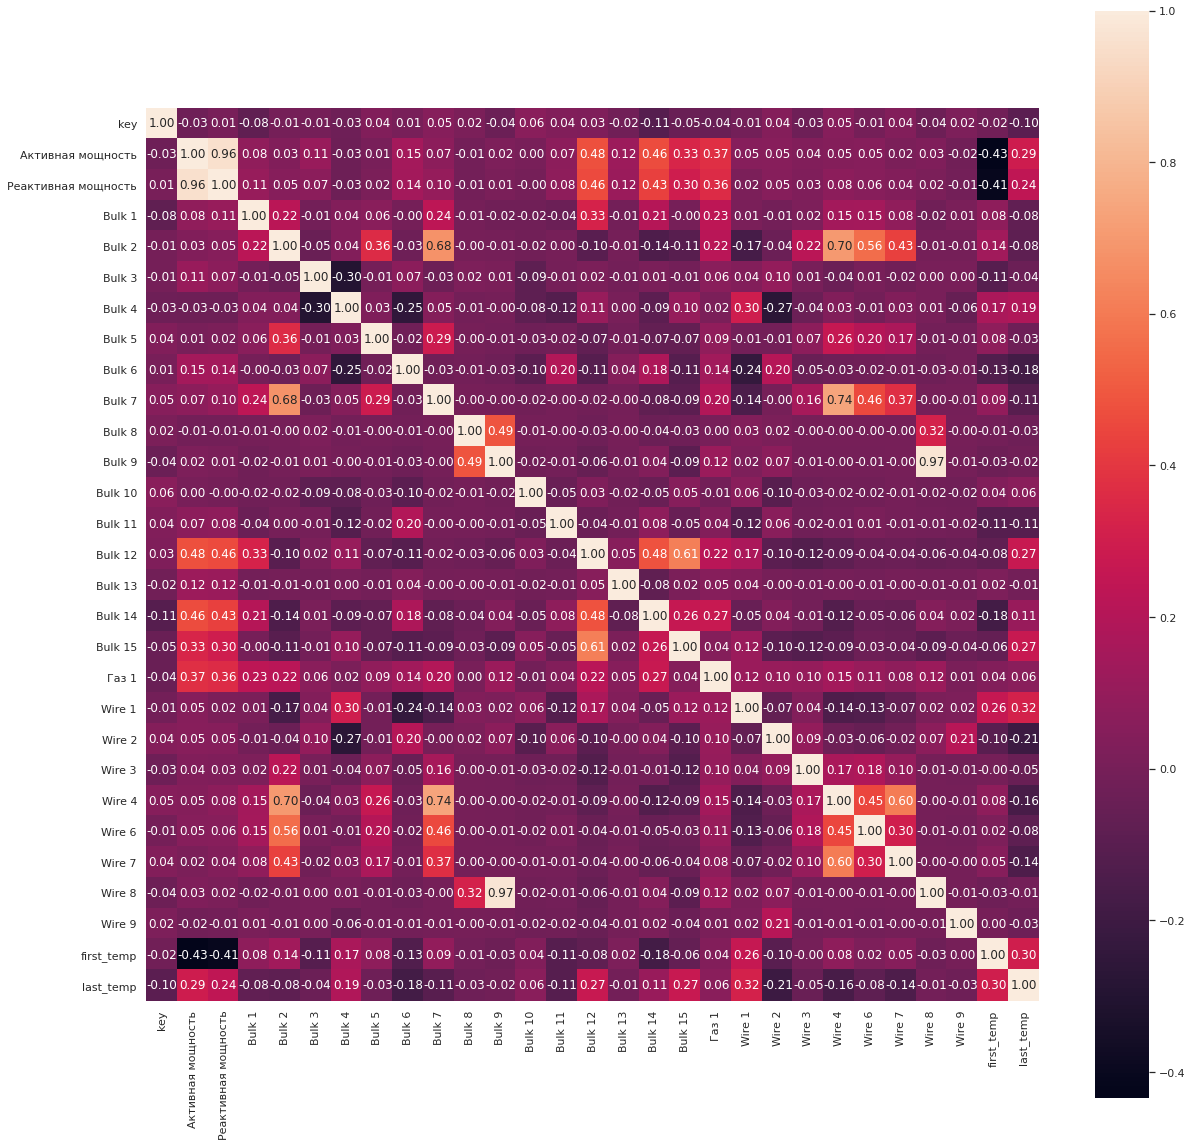

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, square=True, fmt='.2f')
plt.show()

**Вывод**

Наблюдается слабая положительная связь между целевым признаком `last_temp` и признаками `first_temp`, `Wire 1`, `Bulk 15`, `Bulk 12`, `Активная мощность` и `Реактивная мощность`.

Мы наблюдаем строгую функциональную зависимость, которой связаны признаки `Bulk 9` и `Wire 8`, а также можем видеть мультиколлинеарность той или иной степени между некоторыми признаками: например, между `Bulk 2` и `Wire 4`, `Wire 6`, `Bulk 7`, между `Bulk 7` и `Wire 4`, между `Wire 4` и `Wire 7`.

## Обучающая и тестовая выборки

Создадим список признаков и таргета и сохраним в переменных `X` и `y`:

In [ ]:
X = ['Активная мощность', 'Реактивная мощность', 'Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15',
       'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9', 'first_temp']

In [ ]:
y = 'last_temp'

Поделим датасет на обучающую и тестовую выборки в соотношении 3 к 1:

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df[X], 
                                                    df[y], 
                                                    test_size=0.25, 
                                                    random_state=130223)

## Обучение модели

### Линейная регрессия с регуляризацией LASSO

Для первой модели мы будем использовать алгоритм линейной регрессии с регуляризацией  LASSO, чтобы алгоритм мог занулить коэффициенты **неважных** признаков.

В поисках лучшей модели будем перебирать гиперпарамер `alpha`.

Создадим конвейер подготовки количественных признаков:

In [ ]:
num_transformer = make_pipeline(StandardScaler())

Создадим preprocessor для подготовки всех данных:

In [ ]:
preprocessor = ColumnTransformer([('num', num_transformer, X)])

Создадим финальный конвейер для подготовки данных и обучения алгоритма:

In [ ]:
alg = Pipeline(steps=[('prerocessor', preprocessor), 
                      ('estimator', Lasso(random_state=130223))])

Посмотрим на этапы конвейера:

In [ ]:
alg

Pipeline(steps=[('prerocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Активная мощность',
                                                   'Реактивная мощность',
                                                   'Bulk 1', 'Bulk 2', 'Bulk 3',
                                                   'Bulk 4', 'Bulk 5', 'Bulk 6',
                                                   'Bulk 7', 'Bulk 8', 'Bulk 9',
                                                   'Bulk 10', 'Bulk 11',
                                                   'Bulk 12', 'Bulk 13',
                                                   'Bulk 14', 'Bulk 15',
                                                   'Газ 1', 'Wire 1', 'Wire 2',
                                                  

Создадим сетку гиперпараметров для алгоритма линейной регрессии:

In [ ]:
parameters = {
    'estimator__alpha': [0, 0.01, 0.02, 0.03, 0.05, 0.07,
                         0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 2, 10],
    'estimator__max_iter': [300, 500, 1000, 2000]
}

In [ ]:
gs = GridSearchCV(alg,
                  parameters,
                  cv=5,
                  scoring=make_scorer(mean_absolute_error,
                                      greater_is_better=False),
                  n_jobs=2)

Перебираем гиперпараметры:

In [ ]:
gs.fit(train_X, train_y)

/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prerocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Активная '
                                                                          'мощность',
                                                                          'Реактивная '
                                                                          'мощность',
                                                                          'Bulk '
                                                                          '1',
                                                                          'Bulk '
                                      

Лучшие гиперпараметры:

In [ ]:
gs.best_params_

{'estimator__alpha': 0.02, 'estimator__max_iter': 300}

Лучший результат MAE на обучающей выборке:

In [ ]:
-gs.best_score_

6.489723665860055

Посмотрим на величины весов признаков, обучив алгоритм `Lasso` на лучших гиперпараметрах модели. Чем больше по модулю вес признака, тем он важнее:

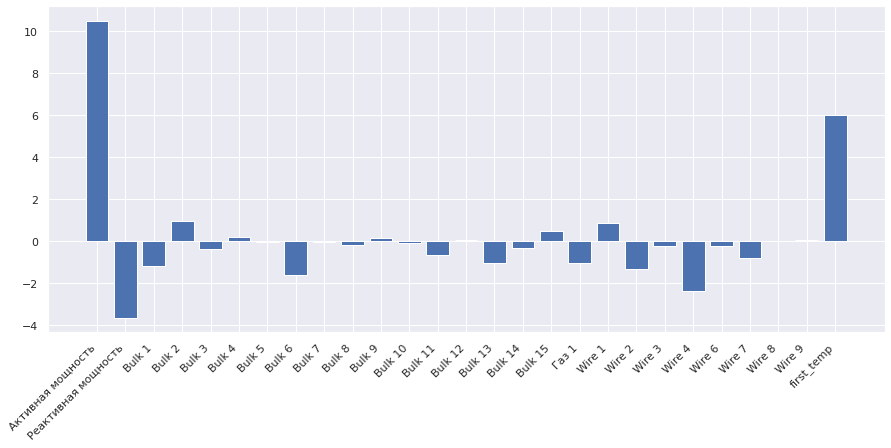

In [ ]:
model = Lasso(random_state=130223, alpha=0.02, max_iter=300)
model.fit(StandardScaler().fit_transform(train_X), train_y)
plt.figure(figsize=(15, 6))
plt.bar(X, model.coef_)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

### Градиентный бустинг from scratch

Алгоритм градиентного бустинга инициализируется константным предсказанием для всех наблюдений, потом считает остатки, т.е. разницу между предсказнным и истинным ответами, и с каждой последующей итерацией обучается на остатках с помощью алгоритма Дерева решений.

Реализуем класс градиентного бустинга:

In [ ]:
class MyGradientBoosting():
    def __init__(self, lr=0.01, iters=1000, max_depth=4):
        self.lr = lr
        self.iters = iters
        self.max_depth = max_depth
        self.models_ = None
        self.constant_prediction_ = None
        self.MAE_ = None

    def fit(self, X, y):
        X = X.values
        y = y.values
        prediction = np.full((y.shape), np.mean(y)) # инициализируем модель константным предсказанием: среднее значение таргета обучающей выборки
        models = [] # в этом списке будем хранить модели Решающего дерева
        MAE = [] # в этом списке будем хранить значение МАЕ каждой итерации

        for _ in range(self.iters):
            residual = y - prediction # считаем остатки
            model = DecisionTreeRegressor(max_depth=self.max_depth, random_state=130223) # инициализируем модель Решающего дерева
            model.fit(X, residual) # обучаемся на остатках
            prediction += model.predict(X) * self.lr # корректируем константное предсказание, компенсируя остатки
            models.append(model) # сохраняем модель в список моделей
            MAE.append(mean_absolute_error(y, prediction)) # сохраняем метрику МАЕ
           
        self.models_ = models
        self.constant_prediction_ = np.mean(y)
        self.MAE_ = MAE

    def predict(self, X):
        X = X.values
        prediction = np.full((X.shape[0]), self.constant_prediction_)

        for model in self.models_:
            prediction += model.predict(X) * self.lr
    
        return prediction   


Инициализируем объект класса `MyGradientBoosting`:

In [ ]:
mgb = MyGradientBoosting()

Так как класс `MyGradientBoosting` не принадлежит библиотеке `scikit-learn` и в нем не реализован метод `get_params`, кросс-валидацию градиентного бустинга проведем с помощью `KFold`:

In [ ]:
cv = KFold(n_splits=5)
MAE = []

for train_index, valid_index in cv.split(train_X.reset_index(drop=True)):
    X_train, y_train = train_X.reset_index(drop=True).loc[train_index], train_y.reset_index(drop=True).loc[train_index]
    X_valid, y_valid = train_X.reset_index(drop=True).loc[valid_index], train_y.reset_index(drop=True).loc[valid_index]
    
    mgb.fit(X_train, y_train)
    pred_valid = mgb.predict(X_valid)
    MAE.append(mean_absolute_error(y_valid, pred_valid))

print(f'Лучший результат MAE на обучающей выборке: {np.min(MAE)}')

Лучший результат MAE на обучающей выборке: 5.6626366233889325


Визуализуем, как улучшалась метрика MAE с каждой последующей итерацией:

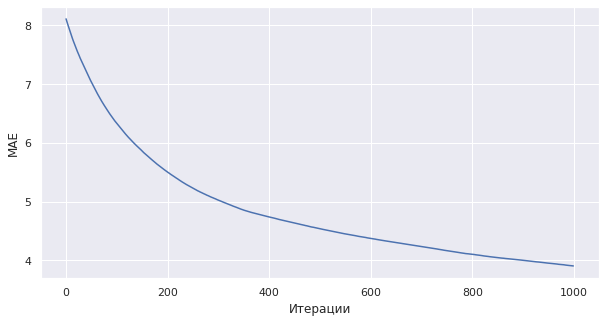

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(mgb.MAE_)
plt.grid(True)
plt.ylabel('MAE')
plt.xlabel('Итерации')
plt.show()

### Вывод

Мы обучили 2 алгоритма: линейная регрессия с регуляриацией LASSO и градиентный бустинг. Лучший результат на обучающей выборке с метрикой качества `MAE=5.66` продемонтрировал градиентный бустинг.

MAE градиентного бустинга на тестовой выборке:

In [ ]:
mean_absolute_error(test_y, mgb.predict(test_X))

6.107613408072331

## Отчет

В ходе работы над проектом нами было сделано следующее:

1. Изучены данные и распределения признаков;

2. Предобработали данные из таблиц, а именно, пропуски в таблицах `data_bulc` и `data_wire` заполнили нулями, аномальные значения в таблицах `data_arc` и `data_temp` удалили или по возможности восстановили; 

2. Из таблицы `data_temp` взяли первое и последнее по времени измерения температуры каждой партии; те партии, для которых первое и последнее значения температуры пропущены, из выборки удалили;

3. Соединили данные в один датафрейм по признаку `key` так, чтобы в одном датасете оказались те партии, которые есть во всех таблицах;

4. Поделили данные на обучающую и тестовую выборки;

5. Обучили алгоритм линейной регрессии с регуляризацией с помощью кросс-валидации:  лучшая метрика МАЕ на обучающей выборке  - 6.49;

6. Создали класс градиентного бустинга с методами `fit` и `predict`, для которого по умолчанию установили 1 000 итераций, скорость обучения =0.01, глубину дерева =4

7. С помощью кросс-валидации обучили алгоритм градиентного бустинга, получив метрику качества МАЕ на обучающей выборке - 5.66 ;

Считаем, что ключевым шагом в решении постановленной задачи была подготовках данных для обучения алгоритмов, а именно: группировка по `key`, восстановление пропущенных значений, поиск и удаление аномальных значиений.

Оба алгоритма обучали на следующих признаках: `['Активная мощность', 'Реактивная мощность', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'first_temp']`. 

По нашему мнению наибольший вклад в предсказание внесли признаки `Активная мощность`, `first_temp` (первое по времени измерение температуры) и `Реактивная мощность`

Итоговой моделью был выбран градиентный бустинг с МАЕ на тестовой выборке - **6.11**. Алгоритм обучали на  **1 000** итераций со скорость обучения **=0.01** и глубиной Дерева решений **=4**.